In [2]:
import pandas as pd, numpy as np
import lbwsg
import lbwsg_boe
import lsff_interventions

!whoami
!date

ndbs
Fri Dec  4 00:37:41 PST 2020


In [3]:
%load_ext autoreload
%autoreload 2

# Define artifact directory

In [4]:
artifact_dir = '/share/costeffectiveness/artifacts/vivarium_conic_lsff/'
artifact_path = f'{artifact_dir}/nigeria.hdf'

# Load fortification data and create an IronFortification object

In [5]:
# Use 3 draws for testing
draws = [0,50,100]

In [52]:
global_data = lsff_interventions.get_global_data(draws)
local_data = lsff_interventions.get_local_data('Nigeria', global_data)

In [53]:
global_data

GlobalIronFortificationData(draws=Int64Index([0, 50, 100], dtype='int64', name='draw'), birthweight_dose_response=draw
0      13.641788
50     16.869422
100     8.154433
Name: birthweight_dose_response, dtype: float64)

In [54]:
local_data

LocalIronFortificationData(location='Nigeria', iron_concentration=40, mean_daily_flour=138.91079478195985, mean_birthweight_shift=draw
0      7.579966
50     9.373379
100    4.530955
Name: mean_birthweight_shift, dtype: float64, eats_fortified=0.08168000000000002, eats_fortifiable=0.25)

In [14]:
iron_intervention = lsff_interventions.IronFortificationIntervention(global_data, local_data)

# Load LBWSG data and create a Distribution object

In [17]:
exposure = lbwsg.read_lbwsg_data(artifact_path, 'exposure',
                                 "age_end < 1", f"year_start == 2017",
                                 draws=global_data.draws) # Check whether passing an Index object works
print(exposure.shape)
exposure.head()

(228, 3)


draw_0  \
location sex    age_start age_end  year_start year_end parameter             
Nigeria  Female 0.0       0.019178 2017       2018     cat10      0.002040   
                                                       cat106     0.000314   
                                                       cat11      0.000544   
                                                       cat116     0.000842   
                                                       cat117     0.003087   

                                                                   draw_50  \
location sex    age_start age_end  year_start year_end parameter             
Nigeria  Female 0.0       0.019178 2017       2018     cat10      0.003515   
                                                       cat106     0.000496   
                                                       cat11      0.000630   
                                                       cat116     0.001198   
                                                       cat117     0.004765   

                                                                  draw_100  
location sex    age_start age_end  year_start year_end parameter            
Nigeria  Female 0.0       0.019178 2017       2018     cat10      0.002040  
                                                       cat106     0.000314  
                                                       cat11      0.000544  
                                                       cat116     0.000842  
                                                       cat117     0.003087

In [18]:
lbwsg_dist = lbwsg.LBWSGDistribution(exposure)

# Create a population table and assign birthweights

In [19]:
pop = lbwsg_boe.initialize_population_table(global_data.draws, 1000) # again, make sure it works to pass an Index
pop.head()

sex  age  age_start   age_end
draw simulant_id                                  
0    0            Female  0.0        0.0  0.019178
     1              Male  0.0        0.0  0.019178
     2            Female  0.0        0.0  0.019178
     3            Female  0.0        0.0  0.019178
     4            Female  0.0        0.0  0.019178

In [33]:
lbwsg_dist.assign_exposure(pop)
pop.head()

sex  age  age_start   age_end lbwsg_cat  ga_propensity  \
draw simulant_id                                                              
0    0            Female  0.0        0.0  0.019178     cat55       0.215386   
     1              Male  0.0        0.0  0.019178     cat10       0.596179   
     2            Female  0.0        0.0  0.019178     cat48       0.910477   
     3            Female  0.0        0.0  0.019178     cat37       0.039248   
     4            Female  0.0        0.0  0.019178     cat56       0.379006   

                  bw_propensity  gestational_age  birthweight  
draw simulant_id                                               
0    0                 0.686523        40.430773  3843.261422  
     1                 0.124716        25.192357   562.357915  
     2                 0.563321        37.910477  3281.660311  
     3                 0.831040        34.078496  2915.520112  
     4                 0.265926        40.758013  4132.963136

# Time the above two steps for various population sizes

### Table initialization:

In [22]:
%timeit lbwsg_boe.initialize_population_table(global_data.draws, 1000)

5.4 ms ± 468 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [23]:
%timeit lbwsg_boe.initialize_population_table(global_data.draws, 100_000)

96 ms ± 11.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Assigning birthweights:

In [26]:
test_pop = lbwsg_boe.initialize_population_table(global_data.draws, 1000)
%timeit lbwsg_dist.assign_exposure(test_pop)

257 ms ± 43 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
test_pop = lbwsg_boe.initialize_population_table(global_data.draws, 10_000)
%timeit lbwsg_dist.assign_exposure(test_pop)

1.83 s ± 177 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
test_pop = lbwsg_boe.initialize_population_table(global_data.draws, 100_000)
%timeit lbwsg_dist.assign_exposure(test_pop)

13.4 s ± 124 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Aha! I've found the culprit -- my code for assigning LBWSG exposure is slow!

Or at least, this is more than 50% of the runtime of the entire BOE calculation. There may be other places that are somewhat slow as well.

I think the problem might be that the function groups by `age_start`, which is a `float`, so it might be getting a unique value for every row in the table rather than finding only one or two unique values. If that's the case, the for loop would be iterating over all rows in the table, which is slow. I will need to test whether this is the case; if so (or in any case), I'll need to add an `age_group` column to the LBWSG data so I can group by that instead.

## Also, see how long it takes to copy a large dataframe:

Not very long.

In [30]:
test_pop.shape

(300000, 9)

In [31]:
%timeit test_pop.copy()

5.85 ms ± 174 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Apply the iron intervention to the baseline population (i.e. do baseline coverage calibration)

In [34]:
iron_intervention.assign_propensities(pop)
pop.head()

sex  age  age_start   age_end lbwsg_cat  ga_propensity  \
draw simulant_id                                                              
0    0            Female  0.0        0.0  0.019178     cat55       0.215386   
     1              Male  0.0        0.0  0.019178     cat10       0.596179   
     2            Female  0.0        0.0  0.019178     cat48       0.910477   
     3            Female  0.0        0.0  0.019178     cat37       0.039248   
     4            Female  0.0        0.0  0.019178     cat56       0.379006   

                  bw_propensity  gestational_age  birthweight  \
draw simulant_id                                                
0    0                 0.686523        40.430773  3843.261422   
     1                 0.124716        25.192357   562.357915   
     2                 0.563321        37.910477  3281.660311   
     3                 0.831040        34.078496  2915.520112   
     4                 0.265926        40.758013  4132.963136   

                  iron_fortification_propensity  \
draw simulant_id                                  
0    0                                 0.949549   
     1                                 0.235305   
     2                                 0.662100   
     3                                 0.788246   
     4                                 0.216607   

                  mother_flour_consumption_propensity  
draw simulant_id                                       
0    0                                       0.254121  
     1                                       0.812284  
     2                                       0.099459  
     3                                       0.721583  
     4                                       0.853824

### Make an intervention population

In [35]:
ipop = pop.copy() # intervention population

### Do baseline calibration in baseline population

In [37]:
iron_intervention.assign_treatment_deleted_birthweight(pop, lbwsg_dist, local_data.eats_fortified)
pop.head()

sex  age  age_start   age_end lbwsg_cat  ga_propensity  \
draw simulant_id                                                              
0    0            Female  0.0        0.0  0.019178     cat55       0.215386   
     1              Male  0.0        0.0  0.019178     cat10       0.596179   
     2            Female  0.0        0.0  0.019178     cat48       0.910477   
     3            Female  0.0        0.0  0.019178     cat37       0.039248   
     4            Female  0.0        0.0  0.019178     cat56       0.379006   

                  bw_propensity  gestational_age  birthweight  \
draw simulant_id                                                
0    0                 0.686523        40.430773  3843.261422   
     1                 0.124716        25.192357   562.357915   
     2                 0.563321        37.910477  3281.660311   
     3                 0.831040        34.078496  2915.520112   
     4                 0.265926        40.758013  4132.963136   

                  iron_fortification_propensity  \
draw simulant_id                                  
0    0                                 0.949549   
     1                                 0.235305   
     2                                 0.662100   
     3                                 0.788246   
     4                                 0.216607   

                  mother_flour_consumption_propensity  \
draw simulant_id                                        
0    0                                       0.254121   
     1                                       0.812284   
     2                                       0.099459   
     3                                       0.721583   
     4                                       0.853824   

                  treatment_deleted_birthweight  
draw simulant_id                                 
0    0                              3842.241092  
     1                               561.337585  
     2                              3280.639980  
     3                              2914.499782  
     4                              4131.942805

In [63]:
iron_intervention.assign_treated_birthweight(pop, lbwsg_dist, local_data.eats_fortified)
pop.head()

sex  age  age_start   age_end lbwsg_cat  ga_propensity  \
draw simulant_id                                                              
0    0            Female  0.0        0.0  0.019178     cat55       0.215386   
     1              Male  0.0        0.0  0.019178     cat10       0.596179   
     2            Female  0.0        0.0  0.019178     cat48       0.910477   
     3            Female  0.0        0.0  0.019178     cat37       0.039248   
     4            Female  0.0        0.0  0.019178     cat56       0.379006   

                  bw_propensity  gestational_age  birthweight  \
draw simulant_id                                                
0    0                 0.686523        40.430773  3843.261422   
     1                 0.124716        25.192357   562.357915   
     2                 0.563321        37.910477  3281.660311   
     3                 0.831040        34.078496  2915.520112   
     4                 0.265926        40.758013  4132.963136   

                  iron_fortification_propensity  \
draw simulant_id                                  
0    0                                 0.949549   
     1                                 0.235305   
     2                                 0.662100   
     3                                 0.788246   
     4                                 0.216607   

                  mother_flour_consumption_propensity  \
draw simulant_id                                        
0    0                                       0.254121   
     1                                       0.812284   
     2                                       0.099459   
     3                                       0.721583   
     4                                       0.853824   

                  treatment_deleted_birthweight  mother_is_iron_fortified  \
draw simulant_id                                                            
0    0                              3842.241092                     False   
     1                               561.337585                     False   
     2                              3280.639980                     False   
     3                              2914.499782                     False   
     4                              4131.942805                     False   

                  mother_daily_flour  birthweight_shift  treated_birthweight  \
draw simulant_id                                                               
0    0                           0.0                0.0          3842.241092   
     1                           0.0                0.0           561.337585   
     2                           0.0                0.0          3280.639980   
     3                           0.0                0.0          2914.499782   
     4                           0.0                0.0          4131.942805   

                 treated_lbwsg_cat  
draw simulant_id                    
0    0                       cat55  
     1                       cat10  
     2                       cat48  
     3                       cat37  
     4                       cat56

# Check means of original birthweight and treated birthweight

Woo hoo, they match!

In [39]:
pop.groupby('draw')[['birthweight', 'treated_birthweight']].mean()

,birthweight,treated_birthweight
draw,,
0,3168.091876,3167.887755
50,3114.587786,3114.546541
100,3140.939505,3140.846141


### What about the variance?

Hmm, in draw 0, the variance of 'treated_birthweight' is slightly **smaller** than the original. The baseline calibration should cause the variance to **increase**...

In [60]:
pop.groupby('draw')[['birthweight', 'treated_birthweight']].var()

,birthweight,treated_birthweight
draw,,
0,427459.046168,427348.783980
50,434225.778092,434229.351428
100,422132.079709,422222.807704


### Even better, look at the distributions of original (GBD) and treated (baesline-calibrated) birthweight

If we had a perfect method of baseline calibration, these two distributions would be identical.

With the approximation we're using, the baseline-calibrated distribution will be slightly more spread out.

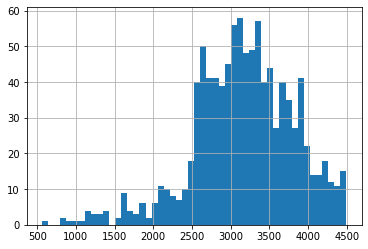

In [56]:
idx=pd.IndexSlice
pop.loc[idx[0,:],'birthweight'].hist(bins=50) # Original GBD birthweight distribution

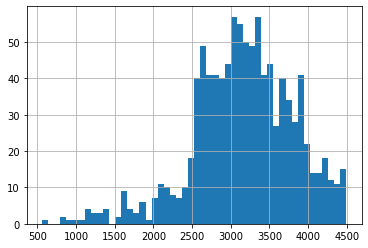

In [57]:
pop.loc[idx[0,:], 'treated_birthweight'].hist(bins=50) # Baseline-calibrated birthweight distribution

# Time the above steps

In [45]:
test_pop = lbwsg_boe.initialize_population_table(global_data.draws, 1000)
lbwsg_dist.assign_exposure(test_pop)
iron_intervention.assign_propensities(test_pop)
%timeit iron_intervention.assign_treatment_deleted_birthweight(test_pop, lbwsg_dist, local_data.eats_fortified)

27.1 ms ± 733 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [46]:
%timeit iron_intervention.assign_treated_birthweight(test_pop, lbwsg_dist, local_data.eats_fortified)

45.8 ms ± 7.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [47]:
test_pop = lbwsg_boe.initialize_population_table(global_data.draws, 10_000)
lbwsg_dist.assign_exposure(test_pop)
iron_intervention.assign_propensities(test_pop)
%timeit iron_intervention.assign_treatment_deleted_birthweight(test_pop, lbwsg_dist, local_data.eats_fortified)

96.7 ms ± 1.69 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [48]:
%timeit iron_intervention.assign_treated_birthweight(test_pop, lbwsg_dist, local_data.eats_fortified)

113 ms ± 995 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [49]:
test_pop = lbwsg_boe.initialize_population_table(global_data.draws, 100_000)
lbwsg_dist.assign_exposure(test_pop)
iron_intervention.assign_propensities(test_pop)
%timeit iron_intervention.assign_treatment_deleted_birthweight(test_pop, lbwsg_dist, local_data.eats_fortified)

1 s ± 30.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [51]:
%timeit iron_intervention.assign_treated_birthweight(test_pop, lbwsg_dist, local_data.eats_fortified)

1.05 s ± 30.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Apply the iron intervention to the intervention population

In [62]:
iron_intervention.assign_treatment_deleted_birthweight(ipop, lbwsg_dist, local_data.eats_fortified)
iron_intervention.assign_treated_birthweight(ipop, lbwsg_dist, local_data.eats_fortifiable)
ipop.head()

sex  age  age_start   age_end lbwsg_cat  ga_propensity  \
draw simulant_id                                                              
0    0            Female  0.0        0.0  0.019178     cat55       0.215386   
     1              Male  0.0        0.0  0.019178     cat10       0.596179   
     2            Female  0.0        0.0  0.019178     cat48       0.910477   
     3            Female  0.0        0.0  0.019178     cat37       0.039248   
     4            Female  0.0        0.0  0.019178     cat56       0.379006   

                  bw_propensity  gestational_age  birthweight  \
draw simulant_id                                                
0    0                 0.686523        40.430773  3843.261422   
     1                 0.124716        25.192357   562.357915   
     2                 0.563321        37.910477  3281.660311   
     3                 0.831040        34.078496  2915.520112   
     4                 0.265926        40.758013  4132.963136   

                  iron_fortification_propensity  \
draw simulant_id                                  
0    0                                 0.949549   
     1                                 0.235305   
     2                                 0.662100   
     3                                 0.788246   
     4                                 0.216607   

                  mother_flour_consumption_propensity  \
draw simulant_id                                        
0    0                                       0.254121   
     1                                       0.812284   
     2                                       0.099459   
     3                                       0.721583   
     4                                       0.853824   

                  treatment_deleted_birthweight  mother_is_iron_fortified  \
draw simulant_id                                                            
0    0                              3842.241092                     False   
     1                               561.337585                      True   
     2                              3280.639980                     False   
     3                              2914.499782                     False   
     4                              4131.942805                      True   

                  mother_daily_flour  birthweight_shift  treated_birthweight  \
draw simulant_id                                                               
0    0                      0.000000           0.000000          3842.241092   
     1                    237.495249          21.473695           582.811280   
     2                      0.000000           0.000000          3280.639980   
     3                      0.000000           0.000000          2914.499782   
     4                    262.502059          23.734745          4155.677550   

                 treated_lbwsg_cat  
draw simulant_id                    
0    0                       cat55  
     1                       cat10  
     2                       cat48  
     3                       cat37  
     4                       cat56

In [64]:
ipop.groupby('draw')[['birthweight', 'treated_birthweight']].mean()

,birthweight,treated_birthweight
draw,,
0,3168.091876,3170.117262
50,3114.587786,3115.447606
100,3140.939505,3141.777541


In [65]:
ipop.groupby('draw')[['birthweight', 'treated_birthweight']].var()

,birthweight,treated_birthweight
draw,,
0,427459.046168,427686.550863
50,434225.778092,433999.752598
100,422132.079709,422169.439216


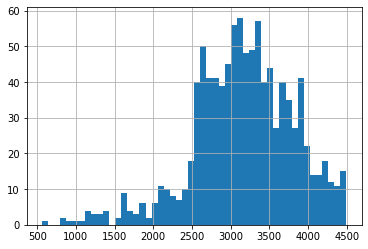

In [66]:
ipop.loc[idx[0,:],'birthweight'].hist(bins=50) # Original GBD birthweight distribution

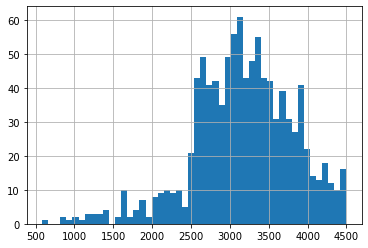

In [67]:
ipop.loc[idx[0,:],'treated_birthweight'].hist(bins=50) # Birthweight distribution after iron fortification

# Load RR data and create a RiskEffect object

In [68]:
rr = lbwsg.read_lbwsg_data(
    artifact_path, 'relative_risk', "age_end < 1", "year_start == 2017", draws=global_data.draws)
rr.head()

draw_0  \
location sex    age_start age_end  year_start year_end affected_entity affected_measure      parameter               
Nigeria  Female 0.0       0.019178 2017       2018     all             excess_mortality_rate cat10      968.702386   
                                                                                             cat106     171.751901   
                                                                                             cat11      513.870580   
                                                                                             cat116     182.396469   
                                                                                             cat117      61.431240   

                                                                                                           draw_50  \
location sex    age_start age_end  year_start year_end affected_entity affected_measure      parameter               
Nigeria  Female 0.0       0.019178 2017       2018     all             excess_mortality_rate cat10      962.766077   
                                                                                             cat106     188.269856   
                                                                                             cat11      543.354131   
                                                                                             cat116     160.502278   
                                                                                             cat117      68.416636   

                                                                                                          draw_100  
location sex    age_start age_end  year_start year_end affected_entity affected_measure      parameter              
Nigeria  Female 0.0       0.019178 2017       2018     all             excess_mortality_rate cat10      986.670297  
                                                                                             cat106     149.651946  
                                                                                             cat11      370.660273  
                                                                                             cat116     157.668181  
                                                                                             cat117      53.245802

In [70]:
lbwsg_effect = lbwsg.LBWSGRiskEffect(rr, paf_data=None)

# Assign relative risks to baseline and intervention populations

In [71]:
lbwsg_effect.assign_relative_risk(pop, cat_colname='treated_lbwsg_cat')
lbwsg_effect.assign_relative_risk(ipop, cat_colname='treated_lbwsg_cat')

In [72]:
pop.head()

sex  age  age_start   age_end lbwsg_cat  ga_propensity  \
draw simulant_id                                                              
0    0            Female  0.0        0.0  0.019178     cat55       0.215386   
     1              Male  0.0        0.0  0.019178     cat10       0.596179   
     2            Female  0.0        0.0  0.019178     cat48       0.910477   
     3            Female  0.0        0.0  0.019178     cat37       0.039248   
     4            Female  0.0        0.0  0.019178     cat56       0.379006   

                  bw_propensity  gestational_age  birthweight  \
draw simulant_id                                                
0    0                 0.686523        40.430773  3843.261422   
     1                 0.124716        25.192357   562.357915   
     2                 0.563321        37.910477  3281.660311   
     3                 0.831040        34.078496  2915.520112   
     4                 0.265926        40.758013  4132.963136   

                  iron_fortification_propensity  \
draw simulant_id                                  
0    0                                 0.949549   
     1                                 0.235305   
     2                                 0.662100   
     3                                 0.788246   
     4                                 0.216607   

                  mother_flour_consumption_propensity  \
draw simulant_id                                        
0    0                                       0.254121   
     1                                       0.812284   
     2                                       0.099459   
     3                                       0.721583   
     4                                       0.853824   

                  treatment_deleted_birthweight  mother_is_iron_fortified  \
draw simulant_id                                                            
0    0                              3842.241092                     False   
     1                               561.337585                     False   
     2                              3280.639980                     False   
     3                              2914.499782                     False   
     4                              4131.942805                     False   

                  mother_daily_flour  birthweight_shift  treated_birthweight  \
draw simulant_id                                                               
0    0                           0.0                0.0          3842.241092   
     1                           0.0                0.0           561.337585   
     2                           0.0                0.0          3280.639980   
     3                           0.0                0.0          2914.499782   
     4                           0.0                0.0          4131.942805   

                 treated_lbwsg_cat  lbwsg_relative_risk  
draw simulant_id                                         
0    0                       cat55             1.000000  
     1                       cat10           911.386377  
     2                       cat48             1.939473  
     3                       cat37            14.255692  
     4                       cat56             1.000000

In [73]:
ipop.head()

sex  age  age_start   age_end lbwsg_cat  ga_propensity  \
draw simulant_id                                                              
0    0            Female  0.0        0.0  0.019178     cat55       0.215386   
     1              Male  0.0        0.0  0.019178     cat10       0.596179   
     2            Female  0.0        0.0  0.019178     cat48       0.910477   
     3            Female  0.0        0.0  0.019178     cat37       0.039248   
     4            Female  0.0        0.0  0.019178     cat56       0.379006   

                  bw_propensity  gestational_age  birthweight  \
draw simulant_id                                                
0    0                 0.686523        40.430773  3843.261422   
     1                 0.124716        25.192357   562.357915   
     2                 0.563321        37.910477  3281.660311   
     3                 0.831040        34.078496  2915.520112   
     4                 0.265926        40.758013  4132.963136   

                  iron_fortification_propensity  \
draw simulant_id                                  
0    0                                 0.949549   
     1                                 0.235305   
     2                                 0.662100   
     3                                 0.788246   
     4                                 0.216607   

                  mother_flour_consumption_propensity  \
draw simulant_id                                        
0    0                                       0.254121   
     1                                       0.812284   
     2                                       0.099459   
     3                                       0.721583   
     4                                       0.853824   

                  treatment_deleted_birthweight  mother_is_iron_fortified  \
draw simulant_id                                                            
0    0                              3842.241092                     False   
     1                               561.337585                      True   
     2                              3280.639980                     False   
     3                              2914.499782                     False   
     4                              4131.942805                      True   

                  mother_daily_flour  birthweight_shift  treated_birthweight  \
draw simulant_id                                                               
0    0                      0.000000           0.000000          3842.241092   
     1                    237.495249          21.473695           582.811280   
     2                      0.000000           0.000000          3280.639980   
     3                      0.000000           0.000000          2914.499782   
     4                    262.502059          23.734745          4155.677550   

                 treated_lbwsg_cat  lbwsg_relative_risk  
draw simulant_id                                         
0    0                       cat55             1.000000  
     1                       cat10           911.386377  
     2                       cat48             1.939473  
     3                       cat37            14.255692  
     4                       cat56             1.000000

# Time the code for assigning relative risks

In [74]:
test_pop.shape

(300000, 17)

In [75]:
%timeit lbwsg_effect.assign_relative_risk(test_pop, cat_colname='treated_lbwsg_cat')

935 ms ± 124 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Compute the PIF

In [76]:
pop.shape

(3000, 18)

In [77]:
pif = lbwsg_boe.population_impact_fraction(pop, ipop, 'lbwsg_relative_risk')
pif

draw
0     -0.000370
50     0.000043
100    0.000000
Name: lbwsg_relative_risk, dtype: float64